In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
data = np.loadtxt("seriesautos.txt", dtype=np.float32)
X_train, Y_train = data[0:83].reshape(1, -1, 1), data[83].reshape(1, -1, 1)

In [0]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(20),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=2200, verbose=2)

In [0]:
X = X_train
for paso in range(10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

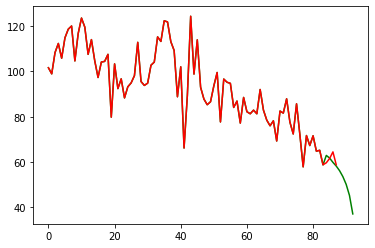

In [0]:
x1 = np.arange(0, 88, 1)
x2 = np.arange(80,88,1)

#plt.plot(x1, data, color = 'r')
#plt.plot(x1, X[0,:88,0], color = 'g')

#plt.plot(x2, data[80:], color = 'r')
#plt.plot(x2, X[0,80:,0], color = 'g')

plt.plot(X[0,:,0], color = 'g')
plt.plot(x1, data, color = 'r')

plt.show()